## Overfitting and Underfitting

过拟合，模型泛化能力差，前面的例子中，模型在训练周期达到一定次数后，模型在验证数据上的准确率会达到峰值，然后便开始下降。

欠拟合，与过拟合相对。说明测试数据仍存在改进空间中。出现这种情况的原因有很多：模型不够强大、过于正则化，或者根本没有训练足够长的时间。

我们需要在两者之间找到平衡。**了解如何训练适当的周期次数是一项很实用的技能，接下来我们将介绍这一技能。**

### 解决过拟合的方案

- 最好的解决方案，更多的训练数据。
- 次优解决方案，使用正则化等技术。

在此 notebook 中，我们将使用两种正则化技术 （权重正则化和丢弃）。

In [15]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

tf.__version__

'2.0.0'

### 准备数据集

我们对影评句子进行多热编码(multi-hot encode)而不是合适嵌入层（embedding layer)。这样模型会很快的过拟合。

> #### 2. 为什么需要进行 One-hot? 又什么进行 Embedding?

> TL;DR; 
> - 进行 One-hot 是为了避免欠拟合 (Underfitting); 
> - 进行 Embedding 是为避免过拟合 (Overfitting)

> 如是一个类别特征不进行 One-hot，那么这个特征就学习到一个参数（在 LR 模型中），那么最终模型就会表现为欠拟合。
> 当我们对特征进行了 One-hot 之后，就可以解决欠拟合的问题了。但是如果为特征的每一个值都学习到一个参数（如决策树中每一个值一个分支），
那么模型就会表现为过拟合。所以我们可以用 Embedding 来解决 One-hot 后的过拟合问题。训练好的 Embedding 层，我们需要保存下来。


In [16]:
NUM_WORDS = 10000

imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words = NUM_WORDS)

我们样本保存的数据是词典中的下标，每个样本的长度是不一样的，因为每个样本的单词数是不一样的。

In [17]:
for i in range(5):
    sample = train_data[i]
    label = train_labels[i]
    print("Sample %d, label = %d, len = %d, data: %s ... %s " % 
          (i+1, label, len(sample), sample[0:3], sample[-3:-1]))

Sample 1, label = 1, len = 218, data: [1, 14, 22] ... [19, 178] 
Sample 2, label = 0, len = 189, data: [1, 194, 1153] ... [16, 145] 
Sample 3, label = 0, len = 141, data: [1, 14, 47] ... [7, 129] 
Sample 4, label = 1, len = 550, data: [1, 4, 2] ... [21, 64] 
Sample 5, label = 0, len = 147, data: [1, 249, 1323] ... [7, 61] 


In [18]:
def multi_hot_sequences(sequences, dimension):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    
    for i, word_indices in enumerate(sequences):
        # set specific indices of results[i] to 1s. 
        # fancy indexing
        results[i, word_indices] = 1.0
    return results

train_data = multi_hot_sequences(train_data, dimension=NUM_WORDS)
test_data = multi_hot_sequences(test_data, dimension=NUM_WORDS)

进行 One-hot 后，我们可以将样本的长度统一。

In [19]:
for i in range(5):
    sample = train_data[i]
    label = train_labels[i]
    print("Sample %d, label = %d, len = %d, data: %s ... %s " % 
          (i+1, label, len(sample), sample[0:3], sample[-3:-1]))

Sample 1, label = 1, len = 10000, data: [0. 1. 1.] ... [0. 0.] 
Sample 2, label = 0, len = 10000, data: [0. 1. 1.] ... [0. 0.] 
Sample 3, label = 0, len = 10000, data: [0. 1. 1.] ... [0. 0.] 
Sample 4, label = 1, len = 10000, data: [0. 1. 1.] ... [0. 0.] 
Sample 5, label = 0, len = 10000, data: [0. 1. 1.] ... [0. 0.] 


因为我们字的下标索引是扫按词频率排序的，所以地索引 0 附近应该有更多的 1 值。如下图所示：

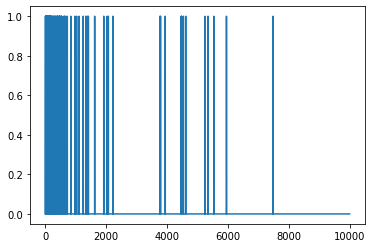

In [22]:
x = np.arange(NUM_WORDS)
plt.plot(x, train_data[0])

### 演示过拟合

在深度学习中，模型中可学习参数的数量通常称之为模型的『容量(capacity)』。直观而言，参数越多的模型其『记忆容量』越大，所以可能到最后轻松学习训练样本与其目标之间的字典式的完美映射（无任何泛化能力的映射）。这样如果对未见过的数据做出预测，那么这种映射毫无用处。

**务必谨记**：深度学习模型往往善于与训练数据拟合，训练拟合的很完美，但*真正的挑战在于泛化*。

但是，如果模型太小，它连与训练数据拟合的可能都没了，这就是所谓的『容量不足』。我们需要在『容量太大』和『容量不足』之间实现平衡。

要找到合适的模型大小，最好先使用相对较少的层和参数，然后开始增加层的大小或添加新的层，直到看到返回的验证损失不断减小为止。我们在影评分类网络上试试这个方法。

我们将仅使用 Dense 层创建一个简单的基准模型，然后创建更小和更大的版本，并比较这些版本。

### 创建基准模型

In [23]:
baseline_model = keras.Sequential([
    # 在第一层中我们需要指定 input size, 之后的就只能指定 output size 即可。
    keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

baseline_model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy', 'binary_crossentropy']
)

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


从上面的模型可以出

- 输入层的参数个数为: (10000 * 16) + 16 = 160016
- 第1隐层的参数个数为: (16 * 16 + 16) = 272
- 第2隐层的参数个数为: （16 * 1 + 1） = 17


In [26]:
baseline_history = baseline_model.fit(
    train_data,
    train_labels,
    epochs = 20,
    batch_size = 512,
    validation_data = (test_data, test_labels),
    verbose = 0
)

#### 创建一个更小的模型

我们创建一个更少的模型，然后与基准模型进行比较。

In [27]:
smaller_model = keras.Sequential([
    keras.layers.Dense(4, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(4, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

smaller_model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy', 'binary_crossentropy']
)

smaller_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


In [29]:
# 使用一个相同的数据训练模型
smaller_history = smaller_model.fit(
    train_data,
    train_labels,
    batch_size = 512,
    epochs=20,
    validation_data=(test_data, test_labels),
    verbose=0
)

#### 创建了一个更大的模型

In [30]:
big_model = keras.Sequential([
    keras.layers.Dense(512, activation=tf.nn.relu, input_shape=(NUM_WORDS, )),
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

big_model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy', 'binary_crossentropy']
)

big_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               5120512   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 5,383,681
Trainable params: 5,383,681
Non-trainable params: 0
_________________________________________________________________


In [31]:
big_history = big_model.fit(
    train_data,
    train_labels,
    batch_size = 512,
    epochs = 20,
    validation_data = (test_data, test_labels),
    verbose = 0
)

### 绘制训练损失和验证损失

实线表示训练损失，虚线表示验证损失 （请谨记：验证损失越低，表示模型越好，模型泛化能力超强）。

在此示例中，较小的网络开始过拟合的时候比基准模型更晚（前者 6 个周期之后，而后者 4 个周期之后）。而较大网络几乎 1 个周期之后便立即开始过拟合了。

网络容量越大，便能够越快的对训练数据进行建模，越容易过拟合。

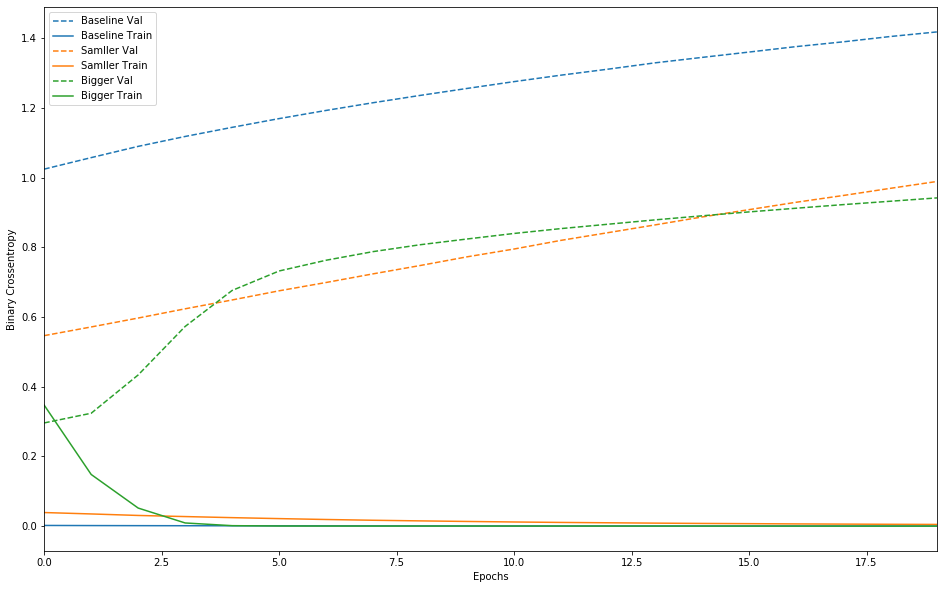

In [32]:
# 实线表示训练损失，虚线表示验证损失

def plot_history(histories, key = 'binary_crossentropy'):
    plt.figure(figsize = (16, 10))
    
    for name, history in histories:
        # 绘制验证集损失
        val = plt.plot(
            history.epoch, 
            history.history['val_' + key],
            '--',
            label = name.title() + ' Val' # 字符串还有 title() 方法
        )
        # 绘制训练损失
        plt.plot(
            history.epoch,
            history.history[key],
            color = val[0].get_color(),
            label = name.title() + ' Train'
        )
    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_', ' ').title())
    plt.legend() 
    plt.xlim([0, max(history.epoch)])
    
plot_history([
    ('baseline', baseline_history),
    ('samller', smaller_history),
    ('bigger', big_history)
])


### 防止过拟合策略

奥卡姆剃刀定律：如果对于同一现象有两种解释，最可能正确的解释是“最简单”的解释，即做出最少量假设的解释。

简单模型比复杂模型更不容易过拟合。“简单模型”是一种参数值分布的熵较低的模型。因此为了缓解过拟合，一种常见的方法是限制网络的复杂性，具体方法是强制要求其权重**仅采用较小的值**。

这种称之为 『权重正则化』，通过向网络的损失函数添加与权重较大相关的代码来实现。有两种类型：

1. L1 正则化，添加的代价与权重系数的 **绝对值（即 L1 范数** 成正比。
2. L2 正则化，添加的代码与权重系统的 **平方 (即 L2 范数)** 成正比。 

L2 正则化在神经网络领域也称为权重衰减。从数学角度来讲，权重衰减与 L2 正则化完全相同。

In [34]:
l2_model = keras.Sequential([
    keras.layers.Dense(
        16, 
        kernel_regularizer = keras.regularizers.l2(0.001),
        activation = tf.nn.relu, 
        input_shape = (NUM_WORDS, )
    ),
    keras.layers.Dense(
        16, 
        kernel_regularizer = keras.regularizers.l2(0.001),
        activation = tf.nn.relu
    ),
    keras.layers.Dense(1, activation = tf.nn.sigmoid)
])

l2_model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy', 'binary_crossentropy']
)

l2_history = l2_model.fit(
    train_data,
    train_labels,
    batch_size = 512,
    epochs = 20,
    validation_data = (test_data, test_labels),
    verbose = 0
)

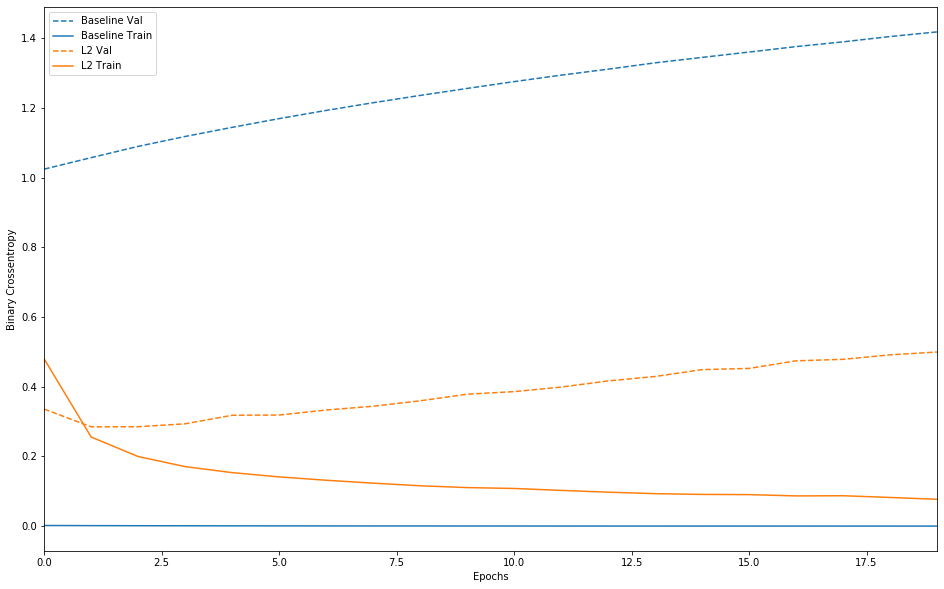

In [35]:
plot_history([
    ('baseline', baseline_history),
    ('L2', l2_history)
])

可以看到，L2 正则化模型的过拟合抵抗能力比基准模型强得多，虽然这两个模型的参数数量相同。

In [36]:
L1_model = keras.Sequential([
    keras.layers.Dense(
        16,
        kernel_regularizer = keras.regularizers.l1(0.001),
        activation = tf.nn.relu,
        input_shape = (NUM_WORDS,)
    ),
    keras.layers.Dense(
        16,
        kernel_regularizer = keras.regularizers.l1(0.001),
        activation = tf.nn.relu
    ),
    keras.layers.Dense(1, activation = tf.nn.sigmoid)
])

L1_model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy', 'binary_crossentropy']
)

L1_history = L1_model.fit(
    train_data,
    train_labels,
    batch_size = 512,
    epochs = 20,
    validation_data = (test_data, test_labels),
    verbose = 0
)

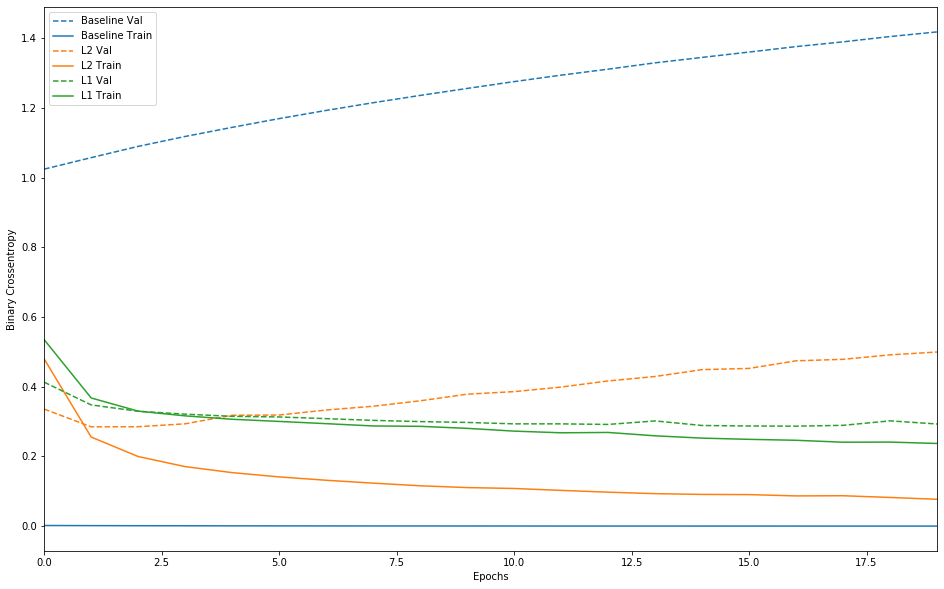

In [37]:
plot_history([
    ('baseline', baseline_history),
    ('L2', l2_history),
    ('L1', L1_history)
])

从上图可以看出 L1 的泛化能力是最好，其在验证集上的表现最好。在图中虚线为验证集上的损失，可以到达的最佳泛化点是 L1 正则。

 [Keras regularizers](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/regularizers) 文档上可以看出还有 [l1_l2](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/regularizers/l1_l2) 正则。那我们也试试这一种吧。

In [38]:
L1_L2_model = keras.Sequential([
    keras.layers.Dense(
        16,
        kernel_regularizer = keras.regularizers.l1_l2(l1 = 0.001, l2 = 0.001),
        activation = tf.nn.relu,
        input_shape = (NUM_WORDS,)
    ),
    keras.layers.Dense(
        16,
        kernel_regularizer = keras.regularizers.l1_l2(l1 = 0.001, l2 = 0.001),
        activation = tf.nn.relu
    ),
    keras.layers.Dense(1, activation = tf.nn.sigmoid)
])

L1_L2_model.compile(
    optimizer = 'adam',
    loss = ['binary_crossentropy'],
    metrics = ['accuracy', 'binary_crossentropy']
)

L1_L2_history = L1_L2_model.fit(
    train_data,
    train_labels,
    batch_size = 512,
    epochs = 20,
    validation_data = (test_data, test_labels),
    verbose = 0
)

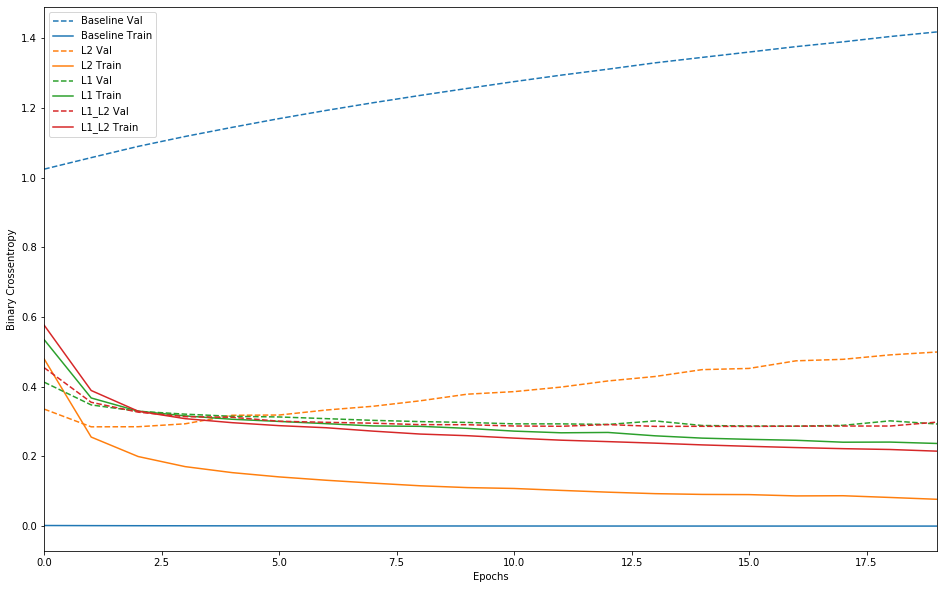

In [39]:
plot_history([
    ('baseline', baseline_history),
    ('L2', l2_history),
    ('L1', L1_history),
    ('L1_L2', L1_L2_history)
])

综合看起来，L1, L1_L2 表现上要好于 L2.

### Dropout

Dropout 是 Hinton 与其学生开发的，是最有效且最常用的神经网络正则化技术。Dropout 是应用在某个层在训练的过程中按照某种概率随机丢弃，即将某层的输出随机设置为 0, 即 『丢弃这些 features』。

**注意**， 在测试时，网络不会丢弃任何单元，而是将某一层的输出值按等于丢弃率的比例进行缩减。这是因为：测试时的活跃单元（active units) 数大于训练时的活跃单元数。

丢弃率一般设置在 `[0.2, 0.5]` 之间。


In [41]:
dropout_model = keras.Sequential([
    keras.layers.Dense(
        16, 
        activation = tf.nn.relu, 
        input_shape = (NUM_WORDS,)
    ),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation = tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation = tf.nn.sigmoid)
])

dropout_model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy', 'binary_crossentropy']
)

dropout_history = dropout_model.fit(
    train_data,
    train_labels,
    batch_size = 512,
    epochs = 20,
    validation_data = (test_data, test_labels),
    verbose = 0
)

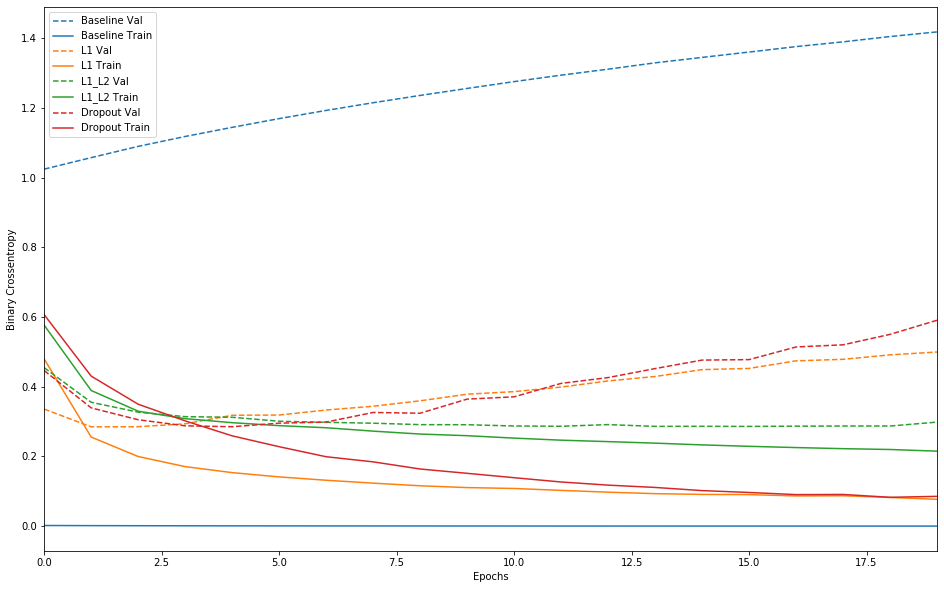

In [42]:
plot_history([
    ('baseline', baseline_history),
    ('L1', l2_history),
    ('L1_L2', L1_L2_history),
    ('dropout', dropout_history)
])

综合看起来 L1_L2 优于 L1 和 Dropout.

添加丢弃层，可以明显改善基准模型。

总结下防止过拟合的最常见方法：

- 获取更多的训练数据
- 降低网络容量（简化模型复杂度）
- 添加权重正则化
- 添加丢弃层。

还有两种重要的方法：

- 数据增强 (data-augumentation)
- 批次归一化 (batch normalization)
